# Gene Prediction Pipeline

## Introduction

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The goal of this notebook is to train the gene prediction algorithm using a 2-stage approach - linear discriminant and neural network. The linear discriminant model reduces high dimensional features and the neural network predicts if a given sequence is a gene or not. My intentions for starting this project were to gain a deeper understanding of machine learning approaches behind the `Orphelia gene prediction algorithm` and sharpen my programming skills. 

See the `Binary-Classification-of-Coding-and-Noncoding-Genes.ipynb` and `examples` folder for example code.

## Google Colab Setup

First clone the `gene-prediction` repository to Google Colab (see setup in `README.md`). Then install dependencies (see code below).

In [1]:
# # Install dependencies
# !pip install -r requirements.txt

# # Install biopython library manually
# !pip3 install biopython

In [ ]:
# # Pull latest code
# !git pull

# Train 2-Stage Binary Classification Algorithm

In [1]:
# Enter your email for the Entrez API 
email = "vignesh.ravindranath@gmail.com"

import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import Entrez
Entrez.email = email

# will inform your notebook to actively reload all 
# imported modules and packages as they are modified
%load_ext autoreload
%autoreload

# self defined modules
from modules import preprocess, extract, train, utils, predict

## Preprocess Genomes

Preprocessing a genome consists of finding all valid open reading frames (ORFs). ORFs start with a start codon (ATG, CTG, GTG, or TGT) and end with an in-frame stop codon (TAG, TGA, or TAA). To train our neural network, we need to find positive ORFs - sequencies that code for a protein (i.e. genes) -  and negative ORFs - sequencies in the genome that start with a start codon and end with an in-frame stop codon, but don't code for a protein. The negative ORFs can be found in the intergenic regions (interregions) of a genome or spaces between genes. 

For this project, positive ORFs will be referred to as CDS or **C**o**D**ing **S**equences, and negative ORFs will be referred to as NCS or **N**on **C**oding **S**equences.

The CDS and NCS data are lists of Biopython **SeqRecord** that contain information about each sequence, such as `ID`, `Name`, `Description`, `Number of features`, and `Seq`.

* `ID` is the GenBank accession number for the prokaryotic genome the sequence was extracted from. 
* `Name` is a auto-generated identifier that the program creates for each sequence. 
* `Description` is blank. 
* `Number of features` includes another Biopython data structure called **SeqFeature** that contains information about the type (CDS or NCS), start location on the genome, the stop location on the genome, and what strand the gene originated from - (+) if it came from the template strand and (-) if it came from the coding strand. 
* `Seq` is another Biopython object that contains the sequence of the gene. 

**NOTE**: the sequence contains a buffer of *30 basepairs upstream of the start codon* and *30 basepairs downstream of the stop codon*. The additional information is necessary to extract the TIS feature.

Input arguments for `preprocess.genome`
* **filename** - txt file containing list of accession numbers (gb genomes)
* **n_genomes** - number of genomes from input file to use for training (=None to train on all genomes in file)
* **OFFSET** - number of basepairs before and after sequence (default is 30 for tis feature)
* **LMIN** - minimin length of ORFs (CDS or NCS) used for training (default is 60 bp ORFs - ref: Hoff et al.)

In [2]:
# preprocess genome into CDS and NCS
filename = './input/train.txt'
n_genomes = 3 # training on first 3 genomes in train.txt

%time _cds, _ncs = preprocess.genome(filename=filename, n_genomes=n_genomes, OFFSET=30, LMIN=60)

Successfully fetched NC_000917
2478 CDS Records, 950 NCS Records

Successfully fetched NC_005966
3241 CDS Records, 1757 NCS Records

Successfully fetched NC_003305
1876 CDS Records, 892 NCS Records

7595 Total CDS Records
3599 Total NCS Records
CPU times: user 1min 49s, sys: 469 ms, total: 1min 50s
Wall time: 3min 32s


In [3]:
print(f'{sys.getsizeof(_cds) / 1000} kB')
print(f'{sys.getsizeof(_ncs) / 1000} kB')

68.456 kB
32.488 kB


In [ ]:
# TODO: batch preprocessing for large inputs of data
# TODO: sample NCS from erlang distribution (see Sampling True NCS Dataset)
# TODO: visualize CDS and NCS distributions

## Shuffle and Split Data

In [4]:
# merge CDS and NCS data
_seq = _cds + _ncs

# delete unused objects
del _cds
del _ncs

# display first three records
for record in _seq[0:3]:
    print(record.name)

AF_RS00005
AF_RS00010
AF_RS00015


In [5]:
# shuffle data
random.seed(8) # set seed for reproducibility 

random.shuffle(_seq)

# display first three records
for record in _seq[0:3]:
    print(record.name)

AF_RS04075
AC_NC00478
ACIAD_RS09065


In [6]:
# split data
m = int(len(_seq)/2)
LD_Data = _seq[0:m]
NN_Data = _seq[m:]

print(f'LD Dataset: {len(LD_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 5597
NN Dataset: 5597


## Train Linear Discriminant Weight Vectors

### Extract Features

The neural network won't be taking an entire ORF sequence as an input. Rather, we will first extract important features and train the neural network on those features. Important features include codon frequency (ex. ATGCCC... => 'ATG', 'CCC', ...) and translation initiation sites (TIS). For codon frequency we can extract monocodon usage (what are all the codons in the sequence) and dicodon usage (what are all the dicodons in the sequence; ex. ATGCCCTTT... => 'ATGCCC', 'CCCTTT', ...). TIS usually occur upstream of the start codon for a codon sequence (gene). So, for the tis feature, we will extract a frame that looks at 30 basepairs (bp) upstream and downstream of start codons (see heatmap below). TIS features are different for discriminant training vs NN training. For discriminant training, TIS features are from CDS only - a TIS frame starting at the true start codon is positive; a TIS frame starting at a start codon within the gene is negative. 

Return types for `extract.training_features`
* **cod_feat** - codon features (monocodon, dicodon)
* **cod_y** - labels for codon features
* **tis_feat** - training tis features
* **tis_y** - labels for training tis features

In [7]:
# extract features: (tri, hex), yc, tis, yt
%time cod_feat, cod_y, tis_feat, tis_y = extract.training_features(LD_Data, OFFSET=30)

CPU times: user 30.7 s, sys: 4.25 s, total: 34.9 s
Wall time: 35.1 s


### Train Discriminants and TIS Gaussian

**Linear Discriminants**

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

**TIS Gaussian**

Ideally, input sequences into the prediction algorithm will contain all the information we need to determine if the sequence is a gene or not. However, next-generation sequencing (NGS) tools often produce fragments of DNA that vary in length from 100 bp to 700 bp. Therefore, the entire TIS region (30 bp upstream of the start codon to 30 bp downstream of the start codon) may not be present in the input sequence. 

To overcome this, a Gaussian distribution can be trained on the training genomes provided. Then, we can predict how likely a given fragment of a TIS window is from a gene or not. 

In [8]:
# train LD discriminant weights
wM = train.discriminant(cod_feat[0], cod_y)
wD = train.discriminant(cod_feat[1], cod_y)
wT = train.discriminant(tis_feat,    tis_y)

# train tis gaussian parameters
# p: ((pi_pos, pi_neg), (mu_pos, mu_neg), (sd_pos, sd_neg))
w = [wM, wD, wT]
p = train.tis_gaussian(tis_feat, tis_y, wT)

print(f'Weights Shape: wM {w[0].shape}, wD {w[1].shape}, wT {w[2].shape}')
print(f'Pos (pi, mu, sd): {round(p[0][0],4)}, {round(p[1][0],4)}, {round(p[2][0],4)}')
print(f'Neg (pi, mu, sd): {round(p[0][1],4)}, {round(p[1][1],4)}, {round(p[2][1],4)}')

Weights Shape: wM (64,), wD (4096,), wT (3712,)
Pos (pi, mu, sd): 0.0378, -0.0476, 0.6411
Neg (pi, mu, sd): 0.9622, -0.9589, 0.1456


<AxesSubplot:>

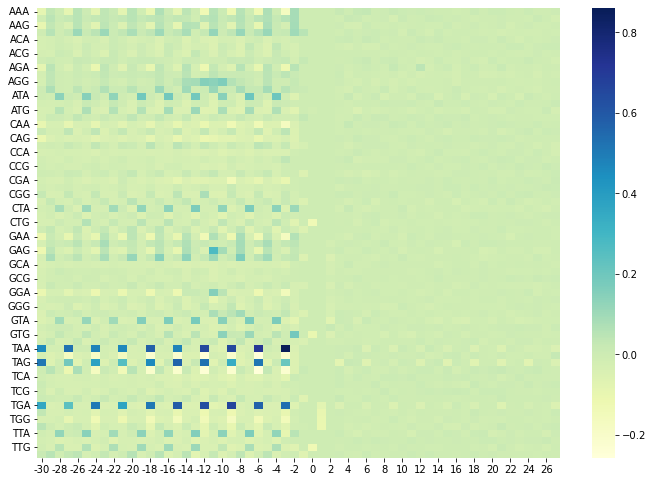

In [9]:
# visualize wT
from modules.utils import populate_codon_idx_dict

tis_weights = np.array(w[2]).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict(nbases=3).keys()
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(tis_weights, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

## Train Binary Classification Neural Network

In [7]:
# load parameters
w, p = utils.load_param("./model/param_3g.csv")

Loaded parameters from disk.


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# suppress tf warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Return types for `extract.features`
* **features** - all features (monocodon, dicodon, tis)
* **y** - labels for features

In [9]:
# extract NN features: (tri, hex, tis, gc), yc
%time NN_features, NN_y = extract.features(NN_Data)

CPU times: user 16.3 s, sys: 391 ms, total: 16.7 s
Wall time: 16.7 s


Return types for `extract.dimensional_reduction`
* **nn_input** - (n,5) matrix of reduced features

Features include:
* x1 = reduced monocodon frequency
* x2 = reduced dicodon frequency
* x3 = positive tis score (gaussian probability)
* x4 = negative tis score (gaussian probability)
* x7 = gc content

In [10]:
# dimensional reduction: 
# X: tri (x1), hex (x2), tis pos (x3), tis neg (x4), gc (x7)
%time nn_input = extract.dimentional_reduction(NN_features, w, p)

CPU times: user 2.02 s, sys: 1.25 s, total: 3.27 s
Wall time: 1.63 s


In [11]:
# shuffle and split data 
X_train, X_test, y_train, y_test = train_test_split(nn_input, np.array(NN_y), test_size=0.2, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4477, 5) (4477,)
(1120, 5) (1120,)


In [12]:
# create model
model = Sequential()
model.add(Dense(25, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2021-09-19 06:40:37.132975: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-19 06:40:37.133663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 06:40:37.135733: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                150       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50


2021-09-19 06:40:37.247061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-19 06:40:37.248165: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592000000 Hz


70/70 [==============================] - 1s 2ms/step - loss: 0.6538 - accuracy: 0.5938
Epoch 2/50
70/70 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.8383
Epoch 3/50
70/70 [==============================] - 0s 2ms/step - loss: 0.3536 - accuracy: 0.8886
Epoch 4/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2840 - accuracy: 0.9068
Epoch 5/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2433 - accuracy: 0.9125
Epoch 6/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2285 - accuracy: 0.9103
Epoch 7/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2222 - accuracy: 0.9112
Epoch 8/50
70/70 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9165
Epoch 9/50
70/70 [==============================] - 0s 1ms/step - loss: 0.2028 - accuracy: 0.9194
Epoch 10/50
70/70 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9183
Epoch 11/50
70/70 [===========

In [15]:
# evaluate model
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 92.50%


### Confusion Matrix

In [50]:
# Confusion matrix
from sklearn import metrics

# make predictions
predictions = model.predict(X_test)

# convert predictions to 1 or 0
y_pred = [1 if val >= 0.5 else 0 for val in predictions]

# create confusion matrix
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

In [54]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[307  59]
 [ 25 729]]


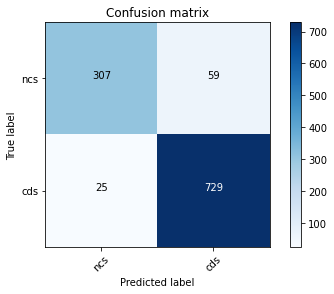

In [56]:
# plot confusion matrix
plot_confusion_matrix(cm, ['ncs','cds'], normalize=False)

## Save

In [22]:
# save NN model to JSON/H5 files
utils.save_model2json("./model/model_3g", model)

Saved model to disk.


In [ ]:
# save discriminant weights + gaus params to csv
data = []
for l in w: data.append(l.tolist())
for l in p: data.append(list(l))
utils.save2csv("./model/param_3g.csv", data)

# Predict Sequences (FASTA)

## Examples of Prediction Module

### Predictions from Genome Sequence

In [ ]:
gb_file = './input/train.txt'           # txt file of genbank accession
n_genomes = 1                           # number of genomes
seq = 'cds'                             # only getting CDS sequences 
outfile = './results/gb_pred_test.fna'  # location of prediction results

params = './model/param_3g.csv'       # saved csv of parameter values (w, p)
model = './model/model_3g'            # saved json/h5 of NN model

In [2]:
%time pg = predict.from_genome(gb_file, params, model, outfile, n_genomes=n_genomes, seq=seq, OFFSET=30, noise=False, LMIN=60)

Successfully fetched NC_000917
2478 CDS Records

2478 Total CDS Records
0 Total NCS Records
Saved genome fragments to ./input/tmp.fna.
Loaded parameters from disk.


2021-09-14 03:48:29.047860: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 03:48:29.048994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-14 03:48:29.052787: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-09-14 03:48:29.195518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-14 03:48:29.197702: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592000000 Hz


Loaded model from disk.
Saved genome fragments to ./results/gb_pred_test.fna.
CPU times: user 1min 2s, sys: 3.16 s, total: 1min 5s
Wall time: 1min 23s


Should expect all the predictions to be close to 1. So the sum should be 2478.

In [5]:
sum(pg)

array([2037.3651], dtype=float32)

In [ ]:
# TODO: explore CDS that weren't predicted as genes

### Predictions from FASTA Input File

In [12]:
gb_file = './input/train.txt'             # txt file of genbank accession
fasta_file = './input/input_test.fna'     # input fasta file
outfile = './results/fasta_pred_test.fna' # location of prediction results

params = './model/param_3g.csv'       # saved csv of parameter values (w, p)
model = './model/model_3g'            # saved json/h5 of NN model

In [9]:
# create example fasta file

# get 'all' (cds, ncs) from first genome of train.txt
_cds, _ncs = preprocess.genome(gb_file, n_genomes=1, seq='all', OFFSET=30, noise=False, LMIN=60)

# get first 5 sequences of cds and ncs records
test_seqs = _cds[0:5] + _ncs[0:5]

# save to fasta file
predict.seqrecord2fasta(filename=fasta_file, seq_records=test_seqs)

Successfully fetched NC_000917
2478 CDS Records, 950 NCS Records

2478 Total CDS Records
950 Total NCS Records
Saved genome fragments to ./input/input_test.fna.


In [13]:
pf = predict.from_fasta(fasta_file, params, model, outfile)

Loaded parameters from disk.
Loaded model from disk.


2021-09-14 03:58:02.347476: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 03:58:02.348261: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-14 03:58:02.350630: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-09-14 03:58:02.439579: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-14 03:58:02.440750: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2592000000 Hz


Saved genome fragments to ./results/fasta_pred_test.fna.


First 5 should be 1's, last 5 should be 0's

In [14]:
pf

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)